In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

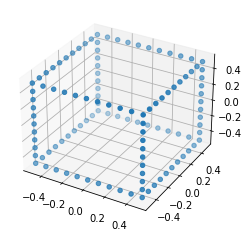

In [2]:
def box3d(n):
    d_x = d_y = d_z = 1 / n
    x0 = y0 = z0 = -0.5
    x = np.arange(x0, -x0, d_x, dtype=float)
    y = np.arange(y0, -y0, d_y, dtype=float)
    z = np.arange(z0, -z0, d_z, dtype=float)
    x = np.append(x,0.5)
    y = np.append(y,0.5)
    z = np.append(z,0.5)
    cube = np.stack(np.meshgrid(x, y, z))
    # print(cube)
    # one = abs(cube[0,:,:,:]) == 0.5
    # two = abs(cube[1,:,:,:]) == 0.5
    # thr = abs(cube[2,:,:,:]) == 0.5
    # w = np.logical_or(one,two)
    # w = np.logical_or(w,thr)
    # points = cube[:,w].reshape(cube[:,w].shape[1], 3)
    # return points # just sides of the cube
    return cube.reshape(3,-1) # cube
    
Q = box3d(10)
ax = plt.axes(projection='3d')
Q = np.swapaxes(Q,0,1)
Q = Q[(abs(Q) == 0.5).sum(axis=1) >= 2]
# ax.scatter3D(Q[0,:],Q[1,:],Q[2,:])
ones = np.ones(Q.shape[0]).reshape(Q.shape[0],1)
Q = np.concatenate((Q,ones),axis=1)
ax.scatter3D(Q[:,0],Q[:,1],Q[:,2])

[[ 0.8660254  0.         0.5        0.       ]
 [ 0.         1.         0.         0.       ]
 [-0.5        0.         0.8660254  4.       ]]
[[-0.17894026]
 [-0.13099336]
 [ 1.        ]]


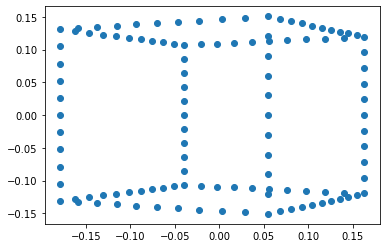

In [3]:
def projectpoints(K, R, t, Q):
    Q.reshape((Q.shape[1],Q.shape[0]))
    T = np.concatenate((R,t),axis=1)
    P = K @ T
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        p = Q[i,:]
        projected = P @ p.reshape(4,1)
        if (p == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(P)
            print(projected/projected[2])
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx,ppsy

K = R = np.eye(3)
theta = np.pi / 6
R = np.array([
    [np.cos(theta), 0, np.sin(theta)],
    [0, 1, 0],
    [-np.sin(theta), 0, np.cos(theta)],
])
t = np.array([[0,0,4]]).T
(ppsx,ppsy) = projectpoints(K,R,t,Q)
plt.scatter(ppsx, ppsy) # 2D image

### Week2

[[600.    0.  400.  600. ]
 [  0.  600.  400.  720. ]
 [  0.    0.    1.    1.5]]
[[100.]
 [220.]
 [  1.]]


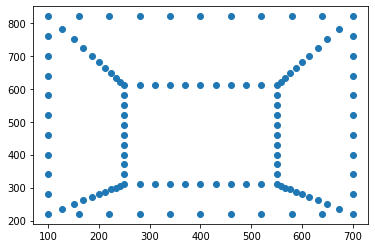

In [4]:
def build_K(f,alpha,beta,deltax,deltay):
    return np.array([
        [f, beta*f, deltax],
        [0, alpha*f, deltay],
        [0, 0, 1]
    ])
f = 600
alpha = 1
beta = 0
deltax = deltay = 400
K = build_K(f,alpha,beta,deltax,deltay)
R = np.eye(3)
t = np.array([[0,.2,1.5]]).T
(ppsx,ppsy) = projectpoints(K,R,t,Q)
plt.scatter(ppsx, ppsy) # 2D image
# TODO: projection matrix (4,4) element doesn't agree with the exercise doc

In [5]:
max(ppsy) # this is out of image sensor 

820.0

In [6]:
def distortion(p, dr):
    dr 
    return p * (1 + dr * np.linalg.norm(p,2))

def tinhom3D(p):
    s = p[3][0]
    for i in range(3):
        p[i][0] /= s
    return p[:3]

def tinhom2D(p):
    s = p[2][0]
    for i in range(2):
        p[i][0] /= s
    return p[:2]

def thom(p):
    return np.append(p,np.ones((1,1)),axis=0)

[[2.10914268e+04]
 [1.28148561e+04]
 [1.00000000e+00]]


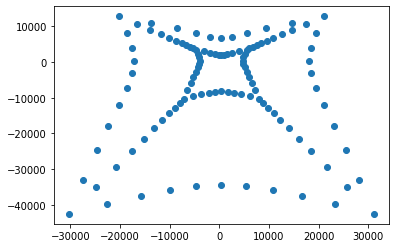

In [7]:
f = 600
alpha = 1
beta = 0
deltax = deltay = 400
K = build_K(f,alpha,beta,deltax,deltay)
R = np.eye(3)
t = np.array([[0,.2,1.5]]).T
Ap = np.array([
    [f,0,0],
    [0,f,0],
    [0,0,1],
])
Aq = np.array([
    [1,beta,deltax],
    [0,alpha,deltay],
    [0,0,1],
])

# data = np.zeros((800,800))
# center = [400, 400]
# y, x = np.indices((data.shape))
# r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
# # import matplotlib.pyplot as plt
# # plt.imshow(r, cmap='gray')

# lecture notes
def projectpoints_dist(K, R, t, Q, dist):
    Q.reshape((Q.shape[1],Q.shape[0]))
    T = np.concatenate((R,t),axis=1)
    # T = np.append(T,np.array([[0,0,0,1]]),axis=0)
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        Qi = Q[i,:].copy()
        pid = Ap @ T @ Qi.reshape(4,1)
        pid = tinhom2D(pid)
        # pid[0][0] -= deltax
        # pid[1][0] -= deltay
        r = np.linalg.norm(pid,2)
        # dr = 0.0
        # for i,d in enumerate(dist):
        #     dr += d*r**((i+1)*2)
        dr = -.2*r
        pic = pid * (1 + dr)
        pic = thom(pic)
        projected = Aq @ pic
        if (Qi == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx,ppsy

dist_coeffs = [1.0,2.0,3.0]
(ppsx,ppsy) = projectpoints_dist(K,R,t,Q,dist_coeffs)
plt.scatter(ppsx, ppsy) # 2D image

[[120.4 ]
 [232.24]
 [  1.  ]]


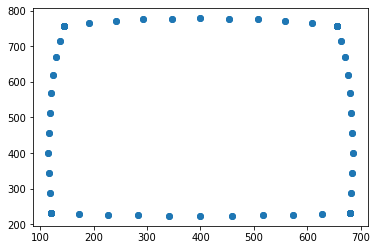

In [8]:
# slides math
def projectpoints_dist(K, R, t, Q, dist):
    Q.reshape((Q.shape[1],Q.shape[0]))
    T = np.concatenate((R,t),axis=1)
    ppsx = []
    ppsy = []
    for i in range(Q.shape[0]):
        Qi = Q[i,:].copy()
        pid = T @ Qi.reshape(4,1)
        pid = pid[:2]
        pid = pid * (1 - .2*np.linalg.norm(pid,2)**2)
        pid = np.append(pid,np.ones((1,1)),axis=0)
        projected = K @ pid
        if (Qi == np.array([-0.5, -0.5, -0.5, 1.0])).all():
            print(projected/projected[2])
        ppsx.append(float(projected[0]/projected[2]))
        ppsy.append(float(projected[1]/projected[2]))
    return ppsx,ppsy

dist_coeffs = [1.0,2.0,3.0]
(ppsx,ppsy) = projectpoints_dist(K,R,t,Q,dist_coeffs)
plt.scatter(ppsx, ppsy) # 2D image

[[875.00544   0.      540.     ]
 [  0.      875.00544 960.     ]
 [  0.        0.        1.     ]]


(1019, 1633, (1080, 1920, 3), (1080, 1920))

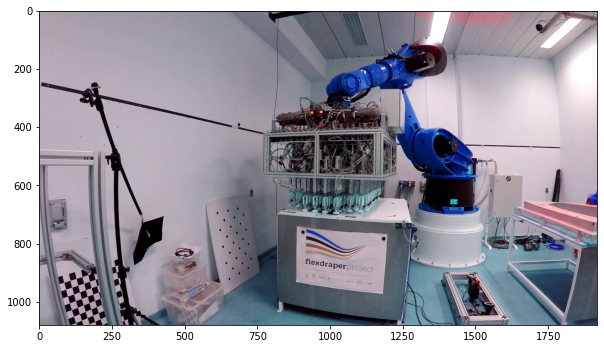

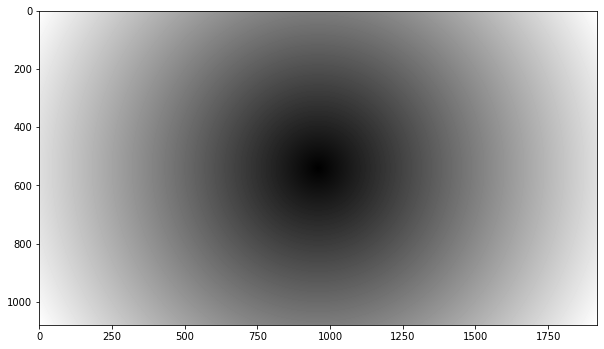

In [9]:
im = cv2.imread('data/gopro_robot.jpg')
fm = 0.455732
plt.figure(1, figsize=(10,10))
plt.imshow(im)
height,width,_ = im.shape
f = width*fm
deltax = height/2 
deltay = width/2
k3 = -0.245031 
k5 = 0.071524
k7 = -0.00994978
dist_coeffs = [k3,k5,k7]
K = build_K(f,alpha,beta,deltax,deltay)
print(K)

data = im
center = [deltay,deltax]
y, x = np.indices((data.shape[:2]))
r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
y = y.astype(np.float64)
ym = y.max()
y /= y.max()
x = x.astype(np.float64)
xm = x.max()
x /= x.max()
r /= r.max()
plt.figure(2, figsize=(10,10))
plt.imshow(r, cmap='gray')

# np.multiply(y,(1+r))

dr = np.zeros_like(r)       
for i,d in enumerate(dist_coeffs):
    dr += d*r**((i+1)*2)

yd = ((y * (1+dr)) * ym).astype(np.int16)
xd = ((x * (1+dr)) * xm).astype(np.int16)
yd.max(),xd.max(),im.shape,yd.shape

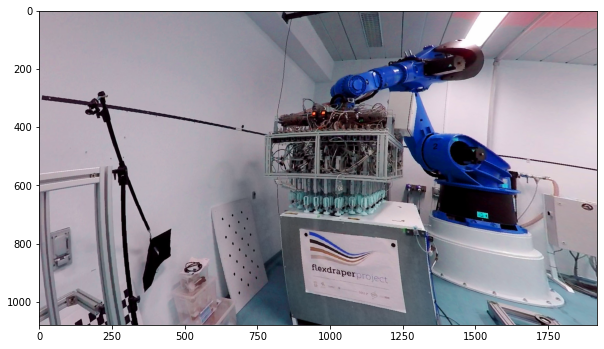

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(im[yd,xd])
# plt.scatter(yd,xd)


# from scipy.interpolate import RegularGridInterpolator
# # TODO: ???
# my_interpolating_function = RegularGridInterpolator((xd, yd), im[yd,xd,0])
# # pts = np.array([[2.1, 6.2, 8.3], [3.3, 5.2, 7.1]])
# # my_interpolating_function(pts)
# xd.shape, im[yd,xd,0].shape

In [11]:
H = np.array([
    [-2,0,1],
    [1,-2,0],
    [0,0,3],
])
def gq(p):
    q=H@p
    return q/q[-1]

p1 = np.ones((3,1))
q1 = gq(p1)
p2 = np.array([[0],[3],[1]])
q2 = gq(p2)
p3 = np.array([[2],[3],[1]])
q3 = gq(p3)
p4 = np.array([[2],[4],[1]])
q4 = gq(p4)

# q1h = H@p1
# q2h = H@p2
# q1 = q1h/q1h[-1]
# q2 = q2h/q2h[-1]
Q1 = np.concatenate((p1,p2,p3,p4),axis=1).T
Q2 = np.concatenate((q1,q2,q3,q4),axis=1).T

In [12]:
def normalize2d(x):
    return (x - x.mean()) / x.std()
normalize2d(Q2[:,:2]), Q2

(array([[ 0.80992387,  0.80992387],
        [ 1.67384267, -1.34987312],
        [-0.05399492, -0.48595432],
        [-0.05399492, -1.34987312]]),
 array([[-0.33333333, -0.33333333,  1.        ],
        [ 0.33333333, -2.        ,  1.        ],
        [-1.        , -1.33333333,  1.        ],
        [-1.        , -2.        ,  1.        ]]))

In [13]:
def hest(q1,q2):
    # i have to store there normalization 
    # params for later use of homography!
    # TODO:
    # q1[:,:2] = normalize2d(q1[:,:2])
    # q2[:,:2] = normalize2d(q2[:,:2])
    Bs = []
    for p,q in zip(q1,q2):
        B = np.kron(p,np.cross(q, np.identity(q.shape[0]) * -1))
        Bs.append(B)
    U,S,V = np.linalg.svd(np.concatenate(Bs,axis=0))
    He = V[-1].reshape(3,3).round(3).T
    return He

t = hest(Q1,Q2)@p1
t = t[:-1]/t[-1]
t

array([[-0.33430233],
       [-0.33430233]])

In [14]:
hest(Q1,Q2)

array([[ 0.459,  0.   , -0.229],
       [-0.229,  0.459,  0.   ],
       [ 0.   , -0.   , -0.688]])

In [15]:
def normalize2d(x):
    return (x - x.mean()) / x.std()


### Exercise 3

In [16]:
from scipy.spatial.transform import Rotation
K1 = K2 = np.array([
    [1000, 0, 300],
    [0, 1000, 200],
    [0, 0, 1],
])
R1 = np.eye(3)
t1 = np.zeros((3,1))
R2 = Rotation.from_euler('xyz', [0.7, -0.5, 0.8]).as_matrix()
t2 = np.array([[.2, 2, 1]]).T

In [17]:
p1 = np.array([[1,.5,4,1]])
px1,py1 = projectpoints(K1, R1, t1, p1)
q1 = np.array([[px1[0],py1[0]]]).T
px2,py2 = projectpoints(K2, R2, t2, p1)
q2 = np.array([[px2[0],py2[0]]]).T
q1,q2

(array([[550.],
        [325.]]),
 array([[582.47256835],
        [185.98985776]]))

In [18]:
def cross_op(p):
    if p.shape != (3,1):
        p = p.reshape(3,1)
    x,y,z = p[0][0], p[1][0], p[2][0] 
    return np.array([
        [0, -z, y],
        [z, 0, -x],
        [-y, x, 0]
    ])
# so it works!
cross_op(np.append(q1,1)) @ np.append(q2,1), np.cross(np.append(q1,1),np.append(q2,1))

(array([ 1.39010142e+02,  3.24725684e+01, -8.70091629e+04]),
 array([ 1.39010142e+02,  3.24725684e+01, -8.70091629e+04]))

In [19]:
E = cross_op(t2) @ R2
F = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
F

array([[ 3.29311881e-07,  8.19396327e-07,  1.79162592e-03],
       [ 5.15532551e-07, -8.76915984e-07,  9.31426656e-05],
       [-1.29882755e-03,  1.51951700e-03, -1.10072682e+00]])

In [20]:
line = F @ np.append(4*q1,4) # the answer applies this to org scaled point, s=4
line 

array([ 8.95620504e-03,  3.66751496e-04, -5.28495581e+00])

In [21]:
np.append(4*q2.T,4) @ F @ np.append(4*q1,4) # this must be zero for point to lie on epipolar line

7.105427357601002e-15

In [22]:
np.append(q2.T,1).T@line # this is shown in lecture notes eq 1.2 
# and this must be zero because p1,p2 are taken from single 3D point

1.7763568394002505e-15

In [6]:
# 3.8
import numpy as np
data = np.load('data/TwoImageData.npy', allow_pickle=True).item()
data

{'im1': array([[17, 17, 14, ..., 19, 18, 20],
        [15, 16, 15, ..., 18, 17, 19],
        [14, 14, 15, ..., 18, 18, 21],
        ...,
        [13, 14, 16, ...,  4,  4,  5],
        [13, 13, 14, ...,  4,  5,  6],
        [12, 13, 14, ...,  6,  6,  5]], dtype=uint8),
 'im2': array([[14, 15, 12, ..., 22, 20, 21],
        [13, 14, 14, ..., 21, 19, 20],
        [13, 12, 13, ..., 19, 20, 22],
        ...,
        [14, 19, 38, ...,  5,  5,  6],
        [27, 56, 90, ...,  5,  6,  7],
        [49, 76, 74, ...,  5,  7,  6]], dtype=uint8),
 'R1': array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 'R2': array([[ 9.97063888e-01,  1.21564307e-04,  7.65740684e-02],
        [-1.37753401e-04,  9.99999969e-01,  2.06135565e-04],
        [-7.65740409e-02, -2.16078666e-04,  9.97063874e-01]]),
 't1': array([[0.],
        [0.],
        [0.]]),
 't2': array([[-0.04594547],
        [-0.00017171],
        [ 0.00157051]]),
 'K': array([[1.41448973e+03, 0.00000000e+00, 4.01393651e+02],
       

In [7]:
im1,im2,R1,R2,t1,t2,K = data['im1'] ,data["im2"] ,data["R1"] ,data["R2"] ,data["t1"] ,data["t2"] ,data["K"]

In [11]:
K1 = K2 = K
from helpers import *
E = cross_op(t2) @ R2
Ftrue = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
Ftrue / np.linalg.norm(Ftrue)

array([[ 3.07914555e-08, -3.61883689e-06,  5.43583727e-04],
       [-4.49876682e-06, -2.24402705e-08,  1.51520136e-01],
       [ 1.95223414e-03, -1.48295604e-01, -9.77264527e-01]])

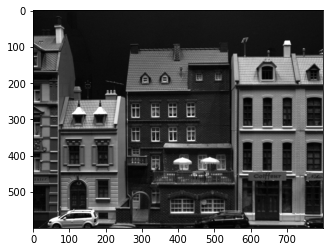

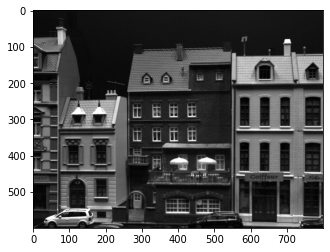

In [25]:
def show2img(im1,im2):
    import matplotlib.pyplot as plt
    plt.figure(1)
    plt.imshow(im1,cmap='gray')
    plt.figure(2)
    plt.imshow(im2,cmap='gray')
show2img(im1,im2)

In [26]:
def DrawLine(l, shape):
    #Checks where the line intersects the four sides of the image
    # and finds the two intersections that are within the frame
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q>=0) and all(q+1<=shape[1::-1]):
            return q
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    print(P); plt.plot(*np.array(P).T)

[array([ -0.       , 496.7786537]), array([799.        , 503.47236858])]


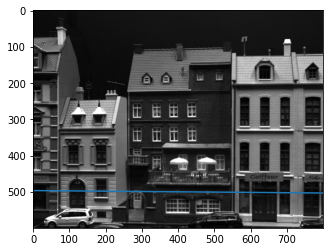

In [27]:
pixel = 500 # point on first image
point_on_the_first = np.array([[pixel,pixel]]).T
# get the epipolar line for this point
E = cross_op(t2) @ R2
F = np.linalg.inv(K).T @ E @ np.linalg.inv(K)
line = F @ np.append(point_on_the_first,1) # the answer applies this to org scaled point, s=4
plt.imshow(im2,cmap='gray')
DrawLine(line,im2.shape)

In [28]:
# P = K @ R @ t
P1 = K @ np.concatenate((R1,t1),axis=1)
P2 = K @ np.concatenate((R2,t2),axis=1)

point = p1.copy()
px1,py1 = projectpoints(K, R1, t1, point)
q1 = np.array([[px1[0],py1[0]]]).T
px2,py2 = projectpoints(K, R2, t2, point)
q2 = np.array([[px2[0],py2[0]]]).T
q1,q2

Q = np.append(np.concatenate([q1,q2],axis=1),np.array([[1,1]]),axis=0).T
P = [P1,P2]

B = [
    P[0][2]*Q[0][0] - P[0][0],
    P[0][2]*Q[0][1] - P[0][1],
    P[1][2]*Q[1][0] - P[1][0],
    P[1][2]*Q[1][1] - P[1][1],
]

B
u,s,v = np.linalg.svd(B)
u.shape,s.shape,v.shape
v[-1]/v[-1][-1],point # EQUAL!

(array([1. , 0.5, 4. , 1. ]), array([[1. , 0.5, 4. , 1. ]]))